In [453]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import HTML, display

## Data preprocess

We want to preprcess data in general then we will go for text
<br>

1. Sanity Check
2. Exploratory Data Analysis (EDA)
3. Missing value treatments
4. Outlier treatments
5. Duplicates and garbage value treatments
6. Normalization (numerical data)
7. Encoding (categorical data)


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c titanic
!unzip titanic.zip

In [184]:
train_df = pd.read_csv("/content/train.csv", index_col = 'PassengerId')
test_df = pd.read_csv("/content/test.csv", index_col = 'PassengerId')
submission = pd.read_csv("/content/gender_submission.csv", index_col = 'PassengerId')

# join test with sumbission based on PassengerId column
test_df = test_df.merge(submission, on = 'PassengerId')

display(HTML((train_df.head(3)).to_html()))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [185]:
test_df.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0


In [186]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [187]:
train_df.describe().map(lambda x: round(x, 2))

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,29.70,0.52,0.38,32.20
std,0.49,0.84,14.53,1.10,0.81,49.69
min,0.00,1.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,38.00,1.00,0.00,31.00
max,1.00,3.00,80.00,8.00,6.00,512.33


In [188]:
train_df.describe(include = 'object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


### Missing value

[Reference](https://pandas.pydata.org/docs/user_guide/missing_data.htmlhttps://pandas.pydata.org/docs/user_guide/missing_data.html)

<br>

- Here are `None` value in pandas data frame:
    - `np.nan`, `pd.NaT`, and `pd.NA` do not act like None (we can't compare them with logical operator)

- Cumulative methods like `cumsum()` and `cumprod()` ignore `NA` values by default, use `skipna = False` to override it

> `isna()` or `notna()`

In [189]:
none_values = {
    'train': train_df.isna().sum() / len(train_df) * 100,
    'test': test_df.isna().sum() / len(test_df) * 100
}

none_values_df = pd.DataFrame(none_values)
none_values_df[(none_values_df['train'] > 0) | (none_values_df['test'] > 0)]

,train,test
Age,19.865320,20.574163
Cabin,77.104377,78.229665
Embarked,0.224467,0.000000
Fare,0.000000,0.239234


### Handle missing value

- `dropna(axis = 0)`:

dropa rows or columns with missing data. default axis is 0, if you want drop columns you should change `axis = 1`

<br>

- `fillna()` replaces NA values with non-NA data.
    - `df.fillna(0)` change all NA values to 0
    - `df.ffill()` fill based on value before NA
    - `df.bfill(limit=1)` fill based on value after NA
    - `df.fillna(df.mean())` we can use mean, median, mode
    - `df.interpolate(limit=1, limit_direction="backward", limit_area="inside")`
> If you are dealing with a time series that is growing at an increasing rate, use `method = 'barycentric'`.<br>
If you have values approximating a cumulative distribution function, use `method = 'pchip'`.<br>
To fill missing values with goal of smooth plotting use `method = 'akima'`.<br>
When interpolating via a polynomial or spline approximation, `order = 2 or 3`. `method="spline", order=2`, `method="polynomial", order=2`

    - `df.replace(np.nan, 0)` or `df.replace({1: 44, 2: 28})`
    - `df.replace(r"\s*\.\s*", np.nan, regex=True)`
    - `df.replace([r"\.", r"(a)"], ["dot", r"\1stuff"], regex=True)`




In [190]:
# Extract proper columns to work with

label = "Survived" # we don't want to make change to this
num_cols = train_df.select_dtypes(include = 'number').columns.tolist()
num_cols.remove(label)

cat_cols = train_df.select_dtypes(include = 'object').columns.tolist()

print("Lable: ", label)
print("Numerical columns: ", num_cols)
print("Categorical columns: ", cat_cols)


Lable:  Survived
Numerical columns:  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [191]:
train_nan = none_values_df[none_values_df['train'] != 0].index.tolist()
test_nan = none_values_df[none_values_df['test'] != 0].index.tolist()

In [ ]:
from sklearn.impute import KNNImputer


imputer = KNNImputer(n_neighbors = 5)
train_df[num_cols] = imputer.fit_transform(train_df[num_cols])
test_df[num_cols] = imputer.transform(test_df[num_cols])


In [193]:
from sklearn.impute import SimpleImputer

cat_imputer = SimpleImputer(strategy = 'most_frequent')
# cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])

In [194]:
none_values = {
    'train': train_df.isna().sum() / len(train_df) * 100,
    'test': test_df.isna().sum() / len(test_df) * 100
}

none_values_df = pd.DataFrame(none_values)
none_values_df

,train,test
Age,0.0,0.0
Cabin,0.0,0.0
Embarked,0.0,0.0
Fare,0.0,0.0
Name,0.0,0.0
Parch,0.0,0.0
Pclass,0.0,0.0
Sex,0.0,0.0
SibSp,0.0,0.0
Survived,0.0,0.0


### Duplicate data

- `Index.is_unique` to check indices, **Not a good approach for a big data**
- `Index.duplicated()`
> drop duplicate indices: `f2.loc[~df2.index.duplicated(), :]`
- `train_df.duplicated()`


### Outlier

1. **IQR (Interquartile Range)**
    - Con: May miss complex multivariate outliers, one row each time (single features)
2. **Z-Score**
    - Cons: assumes normal distribution, sensitive to extreme values affecting mean/std, Only univariate

> $$
\mathbf{Z} = \frac{\mathbf{x} - \mu}{\sigma} \\
\textit{outliers} = \mathbf{Z} > \textit{threshold} \\
\textit{threshold} = 3
$$

```py
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    outliers = z_scores > threshold
    return outliers, z_scores
```

<br>

3. **Isolation Forest;**
```py
from sklearn.ensemble import IsolationForest

def detect_outliers_isolation_forest(data, contamination = 0.1):
    # contamination = 0.05
    iso_forest = IsolationForest(
        contamination=contamination,  # Expected proportion of outliers
        random_state=42
    )
    outliers = iso_forest.fit_predict(data)
    # Returns 1 for inliers, -1 for outliers
    return outliers == -1
```


['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


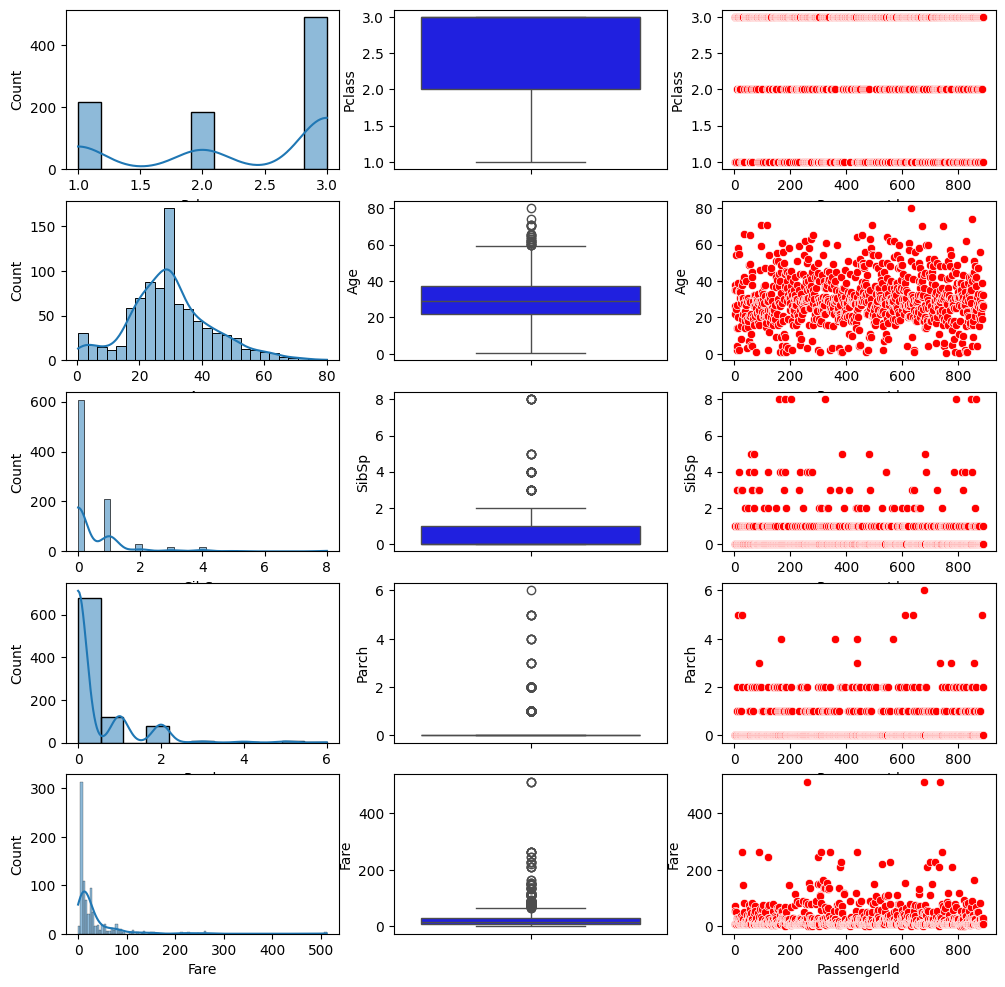

In [195]:
print(num_cols)

fig = plt.figure(figsize = (12, 12))
row, col = len(num_cols), 3
i = 0
for col_name in num_cols:
    fig.add_subplot(row, col, i + 1)
    sns.histplot(train_df[col_name], kde = True)

    fig.add_subplot(row, col, i + 2)
    sns.boxplot(train_df[col_name], color = 'blue')

    fig.add_subplot(row, col, i + 3)
    sns.scatterplot(train_df[col_name], color = 'red')

    i += 3
plt.show()

In [196]:
def remove_outlier(df, cols):
    df_clean = df.copy()
    for col in cols:
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lb = q1 - (1.5 * iqr)
        ub = q3 + (1.5 * iqr)
        df_clean = df_clean[(df_clean[col] >= lb) & (df_clean[col] <= ub)]
    return df_clean

In [197]:
# After checking describe, boxplot and scatter plot I decided ['Age', 'Fare'] have outlier
train_df = remove_outlier(train_df, ['Age', 'Fare'])
test_df = remove_outlier(test_df, ['Age', 'Fare'])

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


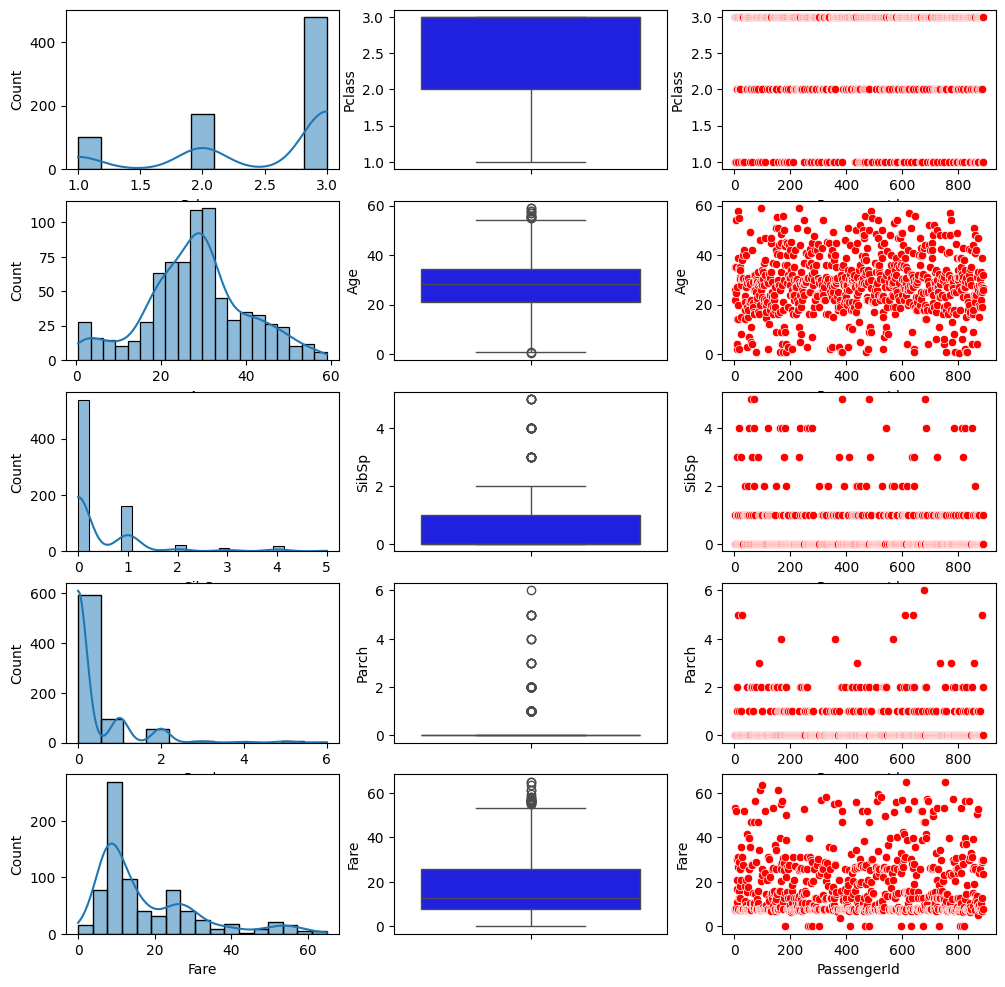

In [198]:
print(num_cols)

fig = plt.figure(figsize = (12, 12))
row, col = len(num_cols), 3
i = 0
for col_name in num_cols:
    fig.add_subplot(row, col, i + 1)
    sns.histplot(train_df[col_name], kde = True)

    fig.add_subplot(row, col, i + 2)
    sns.boxplot(train_df[col_name], color = 'blue')

    fig.add_subplot(row, col, i + 3)
    sns.scatterplot(train_df[col_name], color = 'red')

    i += 3
plt.show()

### Process numerical data

[Reference](https://scikit-learn.org/stable/modules/preprocessing.html)

<br>

 - `StandardScaler`: standardizes features by removing the mean and scaling to unit variance (z-score normalization).
 - `MinMaxScaler`: scales features to a given range (typically [0, 1]).

 > So if we want specific range: `feature_range = (-1, 1)` or do the math like:<br>
 `scaled = (MinMaxScaler().fit_transform(X) * 2) - 1`

- `MaxAbsScaler`: scales in the range [-1, 1]. It is meant for data that is already centered at zero or sparse data.
- `RobustScaler`: If your data contains many outliers,since scaling using the mean and variance not work very well.
- `QuantileTransformer`: provides a non-parametric transformation to map the data to a uniform distribution.
> `output_distribution = 'normal'` map the data to a normal distribution.<br>
Put all features into the same desired distribution based on the formula $G^{-1}(F(X)))$
- `PowerTransformer`:  map data from any distribution to as close to a Gaussian distribution.
 - `normalize(norm = 'l2')` scaling individual samples to have unit norm on a single array-like dataset, either using the `l1`, `l2`, or `max` norms

In [202]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Combine both dataframe to have a same distribution in features
#       Specially in categorical data there might be some features in test split that are not in train split.
df = pd.concat([train_df, test_df])

scaler = StandardScaler()

X_num = df[num_cols]
X_cat = df[cat_cols]
y = df[label]


X_num_scaled = scaler.fit_transform(X_num)

In [203]:
# Check Scaled data
pd.DataFrame(X_num_scaled, columns = num_cols).describe().map(lambda x: round(x, 2))

,Pclass,Age,SibSp,Parch,Fare
count,1116.00,1116.00,1116.00,1116.00,1116.00
mean,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00
min,-2.03,-2.39,-0.49,-0.43,-1.29
25%,-0.66,-0.57,-0.49,-0.43,-0.72
50%,0.71,-0.01,-0.49,-0.43,-0.35
75%,0.71,0.49,0.67,-0.43,0.59
max,0.71,2.86,5.34,7.31,3.42


### Encoding categorical data

- `OrdinalEncoder`: transforms each categorical feature to one new feature of integers `(0 to n_categories - 1)`.
> **not desired**, since it's not continuous.<br>
`OrdinalEncoder(encoded_missing_value=-1)` use SimpleImputer to handle missing value
- `OneHotEncoder`: transforms each categorical feature into `n_categories` binary features, with one of them 1, and all others 0.
> `enc.categories_` to see the categories.<br>
`handle_unknown = 'infrequent_if_exist'` handle missing value and is only supported for one-hot encoding

<br>

> `min_frequency`, `max_frequency`<br>
Sparse Matrix: Only stores non-zero values → Memory efficient: `sparse_output = True`  when we want all valuees it should be `False`

In [204]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

X_cat_enc = enc.fit_transform(X_cat)

In [227]:
# Combine them all
#       Encode array it 2D so we need to stack them vertically then stack them numerical array
X = np.hstack([X_num_scaled, np.vstack(X_cat_enc)])
X.shape, y.shape

((1116, 6), (1116,))

In [229]:
# Now we can split the dataset again
split_len = len(train_df)

X_train, X_test = X[:split_len], X[split_len:]
y_train, y_test = y[:split_len], y[split_len:]

## Text data

- [Twitter Sentiment Analysis](https://www.kaggle.com/datasets/kazanova/sentiment140)
    - !kaggle datasets download kazanova/sentiment140
- [IMDb Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
    - !kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

<br>

### What we need to do
- Lowercasing, punctuation & stopword removal.
- Removing HTML tags, emojis, URLs.
- Lemmatization / stemming.
- Handling missing or short text.
- Encoding text (TF-IDF, tokenization).

In [ ]:
!kaggle datasets download lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

In [ ]:
!python -m spacy download en_core_web_lg

In [281]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 11.0 MB/s eta 0:00:00


In [454]:
import re
import html
import emoji
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [455]:
nlp = spacy.load("en_core_web_lg")

In [522]:
df = pd.read_csv("/content/IMDB Dataset.csv")

display(HTML((df.head(3).to_html())))

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive


In [523]:
# Filter data, remove each review with less than 50 words
df['length_review'] = np.vstack([len(item.split()) for item in df['review']])
len(df), len(df[df['length_review'] > 50])

# Convert sentiment column to ineger
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
display(HTML((df.head(3).to_html())))

,review,sentiment,length_review
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",1,307
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",1,162
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",1,166


In [524]:
# Check for missing values
df.isna().sum() / len(df) * 100

,0
review,0.0
sentiment,0.0
length_review,0.0


In [525]:
stops = list(set(STOP_WORDS) - {'no', 'not', 'never'})

def clean_text(text):

    text = [re.sub(r"\s+", " ", t) for t in text]           # Space
    text = [re.sub(r"<[^>]*>", " ", t) for t in text]       # Tags
    text = [html.unescape(t) for t in text]                 # html entities
    text = [emoji.replace_emoji(t, '') for t in text]       # emoji
    text = [
        re.sub(r'https?://\S+|www\.\S+', '', t) for t in text # URL
    ]

    tokenize = []
    for sentence in text:

        tokenize.append(
            ' '.join([t.lemma_.lower() for t in nlp(sentence) if t not in stops and not t.is_punct and not t.is_digit])
        )

    return  tokenize

In [526]:
# df['review'] = df['review'].apply(clean_text)
from tqdm.auto import tqdm
tokenized = []
df2 = df[:1000]

chunk_size = 100

for i in tqdm(range(0, len(df2), chunk_size)):
    chunk = df2['review'][i: i + chunk_size].tolist()
    # tokenized.extend(clean_text(chunk))
    tokenized.extend(clean_text(chunk))

df2['tokenized'] = tokenized

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipython-input-842780540.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['tokenized'] = tokenized


In [527]:
df2

,review,sentiment,length_review,tokenized
0,One of the other reviewers has mentioned that ...,1,307,one of the other reviewer have mention that af...
1,A wonderful little production. <br /><br />The...,1,162,a wonderful little production the film tech...
2,I thought this was a wonderful way to spend ti...,1,166,i think this be a wonderful way to spend time ...
3,Basically there's a family where a little boy ...,0,138,basically there be a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230,petter mattei 's love in the time of money be ...
...,...,...,...,...
995,Nothing is sacred. Just ask Ernie Fosselius. T...,1,216,nothing be sacred just ask ernie fosselius the...
996,I hated it. I hate self-aware pretentious inan...,0,70,i hate it i hate self aware pretentious inanit...
997,I usually try to be professional and construct...,0,308,i usually try to be professional and construct...
998,If you like me is going to see this in a film ...,0,215,if you like i be go to see this in a film hist...


In [528]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(df2['review'])
y = df2['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [529]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       104
           1       0.78      0.77      0.77        96

    accuracy                           0.79       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.79      0.78       200



In [530]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       104
           1       0.73      0.75      0.74        96

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



In [ ]:
from sentence_transformers import SentenceTransformer

checkpoint = "all-MiniLM-L6-v2"
model = SentenceTransformer(checkpoint)

In [533]:
X = model.encode(df2['review'])
X.shape

(1000, 384)

In [534]:
y = df2['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

In [537]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 22.2 MB/s eta 0:00:00


### Let's do some similarity search

In [553]:
import faiss

d = X.shape[1]
index = faiss.IndexFlatL2(d)
index.add(X)

querry = "I think this is bad movie and would have big impact on every one whatch it. I believe the man actor is one the worst of all time."
querry = model.encode([querry])

D, I = index.search(querry, 2)

for i, idx in enumerate(I[0]):
    print('Score: ', D[0][i])
    print(df2['review'][idx])

Score:  0.7173273
I can't believe it that was the worst movie i have ever seen in my life. i laughed a couple of times. ( probably because of how stupid it was ) If someone paid me to see that movie again i wouldn't. the plot was so horrible , it made no sense , and the acting was so bad that i couldn't even tell if they were trying. that movie was terrible rating: F
Score:  0.7445003
This was probably the worst movie i have ever seen in my life!! It was stupid there was no plot and the special affects were ridiculous!! And i have never seen such bad acting in my life! The only good part about the movie were all the hot guys(especially Drew Fuller). I don't know what these people were thinking when they made this movie!! I didn't even want to finish the whole thing because you get to this point in the movie where the guys are all in bed touching themselves. I mean it was like some kind of sick and twisted kiddy porn! I would advise anyone who has heard of this movie and was interested 

In [ ]:
import faiss

n = 50
d = X.shape[1]
q = faiss.IndexFlatL2(d)
index = faiss.IndexIVFFlat(q, d, n)
index.train(X)
index.add(X)

querry = "I think this is bad movie and would have big impact on every one whatch it. I believe the man actor is one the worst of all time."
querry = model.encode([querry])

index.nprope = 10
D, I = index.search(querry, 2)

for i, idx in enumerate(I[0]):
    print('Score: ', D[0][i])
    print(df2['review'][idx])

Score:  0.7173273
I can't believe it that was the worst movie i have ever seen in my life. i laughed a couple of times. ( probably because of how stupid it was ) If someone paid me to see that movie again i wouldn't. the plot was so horrible , it made no sense , and the acting was so bad that i couldn't even tell if they were trying. that movie was terrible rating: F
Score:  0.7445003
This was probably the worst movie i have ever seen in my life!! It was stupid there was no plot and the special affects were ridiculous!! And i have never seen such bad acting in my life! The only good part about the movie were all the hot guys(especially Drew Fuller). I don't know what these people were thinking when they made this movie!! I didn't even want to finish the whole thing because you get to this point in the movie where the guys are all in bed touching themselves. I mean it was like some kind of sick and twisted kiddy porn! I would advise anyone who has heard of this movie and was interested 

In [549]:
D[0]

array([[0.7173273, 0.7445003]], dtype=float32)